# Miniproyecto 1 Evaluación de Clasificadores

- **Profesor:** Francisco Perez Galarce
- **Ayudante:** Yesenia Salinas

**Integrantes grupo:**
- Jorge Troncoso
- Nicole Villegas
- Exequiel Venegas

In [1]:
# Se importan las librerias a utilizar en este miniproyecto 1
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, recall_score, precision_score, f1_score
import joblib

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.feature_selection import SelectKBest, f_classif

## 1.1 Transformación e imputación de datos

In [2]:
# Función para carga de datos
def cargar_datos(filepath, use_sample=False, columns=None, sample_frac=0.1):
    """
    Carga datos desde un archivo CSV bajo diferentes condiciones.

    Args:
    filepath (str): Ruta o nombre del archivo CSV a cargar.
    use_sample (bool): Indica si se debe cargar una muestra aleatoria del archivo. 
        Si es False, se carga el archivo completo. (Por defecto: False).
    columns (list or None): Lista de nombres de columnas a cargar. Si es None, se cargan todas las columnas. (Por defecto: None).
    sample_frac (float): Fracción de datos a cargar si use_sample=True. 
                         Debe estar entre 0 y 1, donde 1 significa cargar todos los datos. (Por defecto: 0.1).

    Returns:
    pd.DataFrame or None: Un DataFrame con los datos cargados. Si ocurre un error, retorna None.
    """
    # Da error si la ruta no es valida o si se colocan columnas que no estan en el archivo
    try:
        # Cargar el archivo                                               
        df = pd.read_csv(filepath)
        
        # Filtrar columnas si se especifican
        if columns:
            df = df[columns]
        
        # Imprimir tipos de datos para inspección
        print("Tipos de datos en el DataFrame:")
        print(df.dtypes)
        
        # Seleccionar una muestra si es necesario
        if use_sample:
            df = df.sample(frac=sample_frac, random_state=42)
        
        return df
    except Exception as e:
        print(f"Error al cargar datos: {e}")
        return None

In [3]:
# Cargo en una variable df el archivo csv completo con todas sus columnas y filas y lo almaceno como dataframe.
df = cargar_datos('metadatos.csv', False, None)

Tipos de datos en el DataFrame:
patient_id              object
lesion_id                int64
smoke                   object
drink                   object
background_father       object
background_mother       object
age                      int64
pesticide               object
gender                  object
skin_cancer_history     object
cancer_history          object
has_piped_water         object
has_sewage_system       object
fitspatrick            float64
region                  object
diameter_1             float64
diameter_2             float64
diagnostic              object
itch                    object
grew                    object
hurt                    object
changed                 object
bleed                   object
elevation               object
img_id                  object
biopsed                   bool
dtype: object


In [4]:
# Se muestra la info esencial del dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2298 entries, 0 to 2297
Data columns (total 26 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   patient_id           2298 non-null   object 
 1   lesion_id            2298 non-null   int64  
 2   smoke                1494 non-null   object 
 3   drink                1494 non-null   object 
 4   background_father    1480 non-null   object 
 5   background_mother    1476 non-null   object 
 6   age                  2298 non-null   int64  
 7   pesticide            1494 non-null   object 
 8   gender               1494 non-null   object 
 9   skin_cancer_history  1494 non-null   object 
 10  cancer_history       1494 non-null   object 
 11  has_piped_water      1494 non-null   object 
 12  has_sewage_system    1494 non-null   object 
 13  fitspatrick          1494 non-null   float64
 14  region               2298 non-null   object 
 15  diameter_1           1494 non-null   f

El dataframe cotniene 2290 filas y 26 columnas

In [5]:
# Segun lo que se espera, esta es la variable objetivo que tiene los lesiones cutaneas las cuales son 6
df['diagnostic'].unique()

array(['NEV', 'BCC', 'ACK', 'SEK', 'SCC', 'MEL'], dtype=object)

In [6]:
# Se eliminaran las columnas de id ya que estas columnas nunca aportan al modelamiento y pueden introducir ruido innecesario
df = df.drop(columns=['patient_id', 'lesion_id','img_id'])

In [7]:
# Se crea una funcion para analisis descriptivo de variables numericas
# Si se especifican variables tipo object arrojara error al llamar la funcion,y si el parametro columns es None son solo las numericas
def diagnostico_descriptivo(df, calcular_media=False, calcular_std=False, calcular_na=False, calcular_max=False, calcular_min=False, columns=None):
    """
    Generar diagnóstico estadístico de los datos.

    Args:
        df (pd.DataFrame): El DataFrame a analizar.
        calcular_media (bool): Calcular la media de las columnas numéricas.
        calcular_std (bool): Calcular la desviación estándar de las columnas numéricas.
        calcular_na (bool): Contar los valores perdidos en las columnas numéricas.
        calcular_max (bool): Calcular el valor máximo de las columnas numéricas.
        calcular_min (bool): Calcular el valor mínimo de las columnas numéricas.
        columns (list or None): Lista de columnas específicas a incluir (opcional). Si es None, se toman solo columnas numéricas.

    Returns:
        pd.DataFrame: DataFrame con las estadísticas calculadas.

    Raises:
        ValueError: Si se especifican columnas no numéricas.
    """
    # Verificar que el DataFrame no esté vacío
    if df.empty:
        raise ValueError("El DataFrame está vacío.")
    
    # Filtrar columnas numéricas si columns=None
    if columns is None:
        columns = df.select_dtypes(include=np.number).columns.tolist()
    else:
        # Validar que todas las columnas especificadas sean numéricas
        columnas_no_numericas = [col for col in columns if col not in df.select_dtypes(include=np.number).columns]
        if columnas_no_numericas:
            raise ValueError(f"Las siguientes columnas no son numéricas: {columnas_no_numericas}")

    # Inicializar el diccionario de estadísticas
    diagnostico = {}
    if calcular_media:
        diagnostico['Media'] = df[columns].mean()
    if calcular_std:
        diagnostico['Desviación Estándar'] = df[columns].std()
    if calcular_na:
        diagnostico['Valores Perdidos'] = df[columns].isna().sum()
    if calcular_max:
        diagnostico['Máximo'] = df[columns].max()
    if calcular_min:
        diagnostico['Mínimo'] = df[columns].min()
    
    # Convertir a DataFrame y retornar
    return pd.DataFrame(diagnostico)


In [8]:
# Se llama a la funcion para todas las variables numericas del dataframe
diagnostico = diagnostico_descriptivo(
    df, 
    calcular_media=True, 
    calcular_std=True, 
    calcular_na=True, 
    calcular_max=True, 
    calcular_min=True, 
    columns= None
)
print(diagnostico)

                 Media  Desviación Estándar  Valores Perdidos  Máximo  Mínimo
age          60.464752            15.894866                 0    94.0     6.0
fitspatrick   2.265730             0.729029               804     6.0     1.0
diameter_1   11.897055             8.634492               804   100.0     0.0
diameter_2    8.852209             5.797036               804    70.0     0.0


Como en el ejercicio se pide un diagnostico que retorne la media, desviación estandard, maximo y minimo, estos son estadisticos solo para variables numericas, por ende los faltantes en esta funcion solo seran para numericas, por lo que a continuación se realizara la muestra de faltantes para el df completo

In [9]:
# Visualizar valores nulos
print("Valores nulos:")
print(df.isna().sum())

Valores nulos:
smoke                  804
drink                  804
background_father      818
background_mother      822
age                      0
pesticide              804
gender                 804
skin_cancer_history    804
cancer_history         804
has_piped_water        804
has_sewage_system      804
fitspatrick            804
region                   0
diameter_1             804
diameter_2             804
diagnostic               0
itch                     0
grew                     0
hurt                     0
changed                  0
bleed                    0
elevation                0
biopsed                  0
dtype: int64


Aparte de las columnas numericas, hay varias columnas tipo object que tambien tienen datos faltantes a continuacion con una función se realizaran las imputaciones correspondientes.

In [10]:
# Función ajustada para imputar datos faltantes
def imputar_datos(df, columns, strategies):
    """
    Imputar datos faltantes según diferentes estrategias.

    Args:
        df (pd.DataFrame): DataFrame original.
        columns (list): Lista de columnas a imputar.
        strategies (list): Lista de estrategias para cada columna ('mean', 'median', 'mode').

    Returns:
        pd.DataFrame: Nuevo DataFrame con valores imputados.
    """
    imputado = df.copy()
    for col, strategy in zip(columns, strategies):
        if col not in imputado.columns:
            print(f"Advertencia: La columna '{col}' no existe en el DataFrame. Se omitirá.")
            continue

        if strategy == 'mean' and np.issubdtype(imputado[col].dtype, np.number):
            imputado[col].fillna(imputado[col].mean(), inplace=True)
        elif strategy == 'median' and np.issubdtype(imputado[col].dtype, np.number):
            imputado[col].fillna(imputado[col].median(), inplace=True)
        elif strategy == 'mode':
            imputado[col].fillna(imputado[col].mode()[0], inplace=True)
        else:
            print(f"Estrategia desconocida o inapropiada para la columna '{col}': {strategy}")
    return imputado

In [11]:
# Columnas con valores faltantes y sus estrategias de imputación
columns_to_impute = [
    'smoke', 'drink', 'background_father', 'background_mother', 'pesticide',
    'gender', 'skin_cancer_history', 'cancer_history', 'has_piped_water',
    'has_sewage_system', 'fitspatrick', 'diameter_1', 'diameter_2'
]

strategies = [
    'mode', 'mode', 'mode', 'mode', 'mode',
    'mode', 'mode', 'mode', 'mode', 
    'mode', 'median', 'mean', 'mean'
]

# Aplicar la función de imputación
df_imputado = imputar_datos(df, columns_to_impute, strategies)

# Verificar que no queden valores NaN
if df_imputado.isna().any().any():
    print("Existen valores NaN después de la imputación.")
else:
    print("Todos los valores faltantes han sido imputados correctamente.")

Todos los valores faltantes han sido imputados correctamente.


Se uso como estrategia la moda para las variables categorica (al ser tipo object) y para las numericas (que son tipo flotante) la mediana y la media, ademas se asumio que los valores faltantes son totalmente aleatorios y que imputaremos asumiendo esto.

In [12]:
# Se muestran los cambios en la distribución de las columnas imputadas

# Lista de columnas imputadas
columnas_imputadas = [
    'smoke', 'drink', 'background_father', 'background_mother', 'pesticide',
    'gender', 'skin_cancer_history', 'cancer_history', 'has_piped_water',
    'has_sewage_system', 'fitspatrick', 'diameter_1', 'diameter_2'
]

# Diccionario para almacenar las comparaciones
cambios_distribucion = {}

# Comparar distribuciones para cada columna
for col in columnas_imputadas:
    if col not in df.columns or col not in df_imputado.columns:
        print(f"Advertencia: La columna '{col}' no existe en uno de los DataFrames. Se omitirá.")
        continue

    # Estadísticas antes y después de la imputación
    distribucion_original = df[col].describe()
    distribucion_imputada = df_imputado[col].describe()
    
    # Almacenar en el diccionario
    cambios_distribucion[col] = {
        "Antes de la imputación": distribucion_original.to_dict(),
        "Después de la imputación": distribucion_imputada.to_dict()
    }

# Imprimir los resultados
for col, cambio in cambios_distribucion.items():
    print(f"Columna: {col}")
    print("Antes de la imputación:")
    for k, v in cambio["Antes de la imputación"].items():
        print(f"  {k}: {v}")
    print("Después de la imputación:")
    for k, v in cambio["Después de la imputación"].items():
        print(f"  {k}: {v}")
    print("\n")


Columna: smoke
Antes de la imputación:
  count: 1494
  unique: 2
  top: False
  freq: 1292
Después de la imputación:
  count: 2298
  unique: 2
  top: False
  freq: 2096


Columna: drink
Antes de la imputación:
  count: 1494
  unique: 2
  top: False
  freq: 1126
Después de la imputación:
  count: 2298
  unique: 2
  top: False
  freq: 1930


Columna: background_father
Antes de la imputación:
  count: 1480
  unique: 13
  top: POMERANIA
  freq: 530
Después de la imputación:
  count: 2298
  unique: 13
  top: POMERANIA
  freq: 1348


Columna: background_mother
Antes de la imputación:
  count: 1476
  unique: 11
  top: POMERANIA
  freq: 533
Después de la imputación:
  count: 2298
  unique: 11
  top: POMERANIA
  freq: 1355


Columna: pesticide
Antes de la imputación:
  count: 1494
  unique: 2
  top: False
  freq: 897
Después de la imputación:
  count: 2298
  unique: 2
  top: False
  freq: 1701


Columna: gender
Antes de la imputación:
  count: 1494
  unique: 2
  top: FEMALE
  freq: 753
Después 

**¿Cómo Cambió la Distribución?**

Datos Categóricos: La imputación con la moda no alteró significativamente las distribuciones, pero llenó los valores faltantes con la categoría dominante.

Datos Numéricos: La imputación con la media y la mediana preservó las tendencias generales de las distribuciones, mientras que redujo la dispersión en algunas columnas.

Impacto General: Los valores imputados no introdujeron sesgos importantes, y la estructura general de los datos se mantuvo, lo cual es ideal para garantizar que los modelos de aprendizaje automático no se vean afectados negativamente.

In [13]:
# Dataframe con imputaciones 
df_imputado

,smoke,drink,background_father,background_mother,age,pesticide,gender,skin_cancer_history,cancer_history,has_piped_water,...,diameter_1,diameter_2,diagnostic,itch,grew,hurt,changed,bleed,elevation,biopsed
0,False,False,POMERANIA,POMERANIA,8,False,FEMALE,False,True,True,...,11.897055,8.852209,NEV,False,False,False,False,False,False,False
1,False,False,POMERANIA,POMERANIA,55,False,FEMALE,True,True,True,...,6.000000,5.000000,BCC,True,True,False,True,True,True,True
2,False,False,POMERANIA,POMERANIA,77,False,FEMALE,False,True,True,...,11.897055,8.852209,ACK,True,False,False,False,False,False,False
3,False,False,POMERANIA,POMERANIA,75,False,FEMALE,False,True,True,...,11.897055,8.852209,ACK,True,False,False,False,False,False,False
4,False,True,POMERANIA,POMERANIA,79,False,MALE,True,False,False,...,5.000000,5.000000,BCC,True,True,False,False,True,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2293,False,False,POMERANIA,POMERANIA,73,False,FEMALE,False,True,True,...,11.897055,8.852209,ACK,True,False,False,False,False,False,False
2294,False,False,POMERANIA,POMERANIA,55,False,FEMALE,True,True,True,...,13.000000,12.000000,BCC,True,True,False,True,False,False,True
2295,False,False,POMERANIA,POMERANIA,74,False,FEMALE,False,True,True,...,11.897055,8.852209,SEK,False,False,False,False,False,False,False
2296,False,False,POMERANIA,POMERANIA,58,True,FEMALE,True,True,False,...,5.000000,4.000000,BCC,True,False,False,False,False,True,True


In [14]:
# Visualizar valores nulos
print("Valores nulos despues de la limpieza:")
print(df_imputado.isna().sum())

Valores nulos despues de la limpieza:
smoke                  0
drink                  0
background_father      0
background_mother      0
age                    0
pesticide              0
gender                 0
skin_cancer_history    0
cancer_history         0
has_piped_water        0
has_sewage_system      0
fitspatrick            0
region                 0
diameter_1             0
diameter_2             0
diagnostic             0
itch                   0
grew                   0
hurt                   0
changed                0
bleed                  0
elevation              0
biopsed                0
dtype: int64


In [15]:
# Info principal df impoutado
df_imputado.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2298 entries, 0 to 2297
Data columns (total 23 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   smoke                2298 non-null   bool   
 1   drink                2298 non-null   bool   
 2   background_father    2298 non-null   object 
 3   background_mother    2298 non-null   object 
 4   age                  2298 non-null   int64  
 5   pesticide            2298 non-null   bool   
 6   gender               2298 non-null   object 
 7   skin_cancer_history  2298 non-null   bool   
 8   cancer_history       2298 non-null   bool   
 9   has_piped_water      2298 non-null   bool   
 10  has_sewage_system    2298 non-null   bool   
 11  fitspatrick          2298 non-null   float64
 12  region               2298 non-null   object 
 13  diameter_1           2298 non-null   float64
 14  diameter_2           2298 non-null   float64
 15  diagnostic           2298 non-null   o

Como se visualiza ya no quedan valores perdidos.

In [16]:
# Funcion para generar 2 graficos se eligio scatter y boxplot, en el otro bloque se da la explicación del por que
def scatter_box_plot(df, var_x, var_y=None, plot_type="scatter", save=False, filename="plot.png"):
    """
    Generar scatter plots, box plots, histogramas o gráficos de torta.

    Args:
        df (pd.DataFrame): DataFrame con los datos.
        var_x (str): Variable en el eje X.
        var_y (str): Variable en el eje Y (opcional, para scatter y box plots).
        plot_type (str): Tipo de gráfico ('scatter', 'box', 'histogram', 'pie').
        save (bool): Si se debe guardar el gráfico.
        filename (str): Nombre del archivo para guardar el gráfico.

    Returns:
        None
    """
    # Validar si las columnas existen
    if var_x not in df.columns or (var_y and var_y not in df.columns):
        print(f"Error: Una o ambas columnas ({var_x}, {var_y}) no existen en el DataFrame.")
        return
    
    # Configurar tamaño de figura
    plt.figure(figsize=(6, 3))
    
    # Generar gráficos según el tipo
    if plot_type == "scatter" and var_y is not None:
        sns.scatterplot(x=var_x, y=var_y, data=df)
        plt.title(f"Scatter Plot: {var_x} vs {var_y}")
        plt.xlabel(var_x)
        plt.ylabel(var_y)
    elif plot_type == "box":
        sns.boxplot(x=var_x, y=var_y, data=df)
        plt.title(f"Box Plot: {var_x} vs {var_y}")
        plt.xlabel(var_x)
        plt.ylabel(var_y)
    elif plot_type == "histogram":
        sns.histplot(df[var_x], kde=True)
        plt.title(f"Histogram of {var_x}")
        plt.xlabel(var_x)
        plt.ylabel("Frequency")
    elif plot_type == "pie" and var_y is None:
        df[var_x].value_counts().plot.pie(autopct='%1.1f%%')
        plt.title(f"Pie Chart of {var_x}")
    else:
        print("Tipo de gráfico inválido o variables no proporcionadas.")
        return
    
    # Guardar gráfico si se solicita
    if save:
        plt.savefig(filename)
    
    # Mostrar el gráfico
    plt.show()

Generando Scatter Plot: age vs fitspatrick


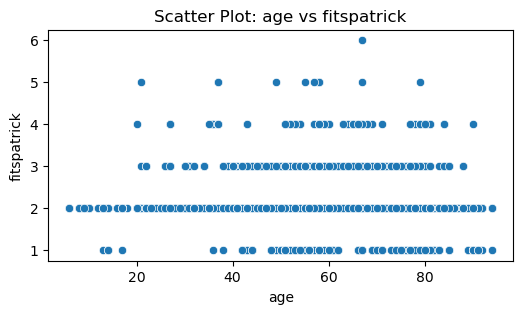

Generando Scatter Plot: age vs diameter_1


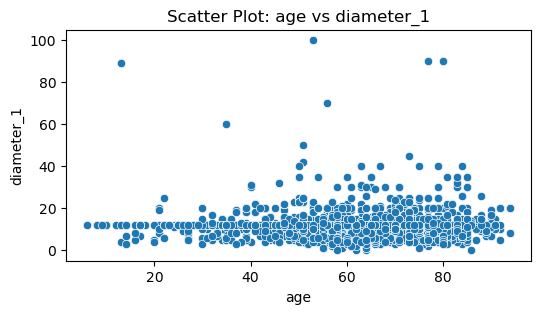

Generando Scatter Plot: fitspatrick vs diameter_1


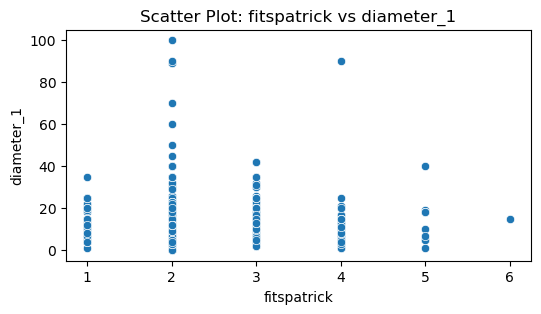

Generando Box Plot: age por diagnostic


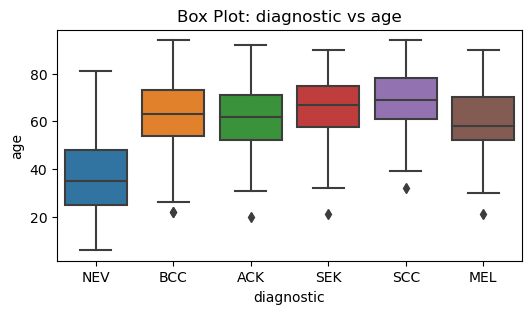

Generando Box Plot: fitspatrick por diagnostic


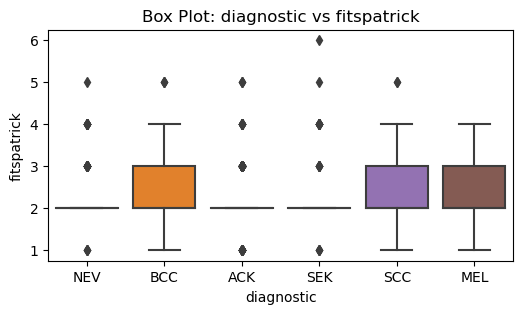

Generando Box Plot: diameter_1 por diagnostic


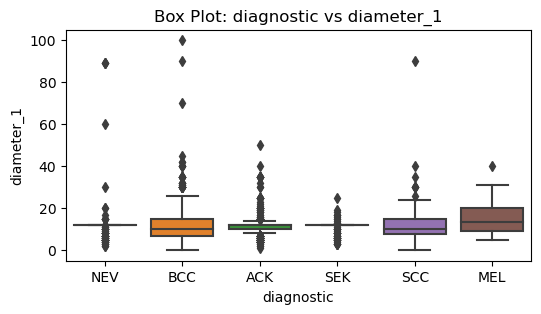

In [17]:
# Identificar columnas numéricas y categóricas en el DataFrame
numerical_columns = df_imputado.select_dtypes(include=['number']).columns.tolist()  # Columnas numéricas
categorical_columns = df_imputado.select_dtypes(include=['object', 'category']).columns.tolist()  # Columnas categóricas

# Limitar las combinaciones a las columnas más relevantes
selected_numerical_columns = numerical_columns[:3]  # Limitar a las 3 primeras numéricas
selected_categorical_columns = ['diagnostic']  # Usar solo la variable categórica 'diagnostic'

# Generar Scatter Plots: solo combinaciones limitadas
for i, var_x in enumerate(selected_numerical_columns):
    for var_y in selected_numerical_columns[i+1:]:
        print(f"Generando Scatter Plot: {var_x} vs {var_y}")
        scatter_box_plot(df_imputado, var_x=var_x, var_y=var_y, plot_type="scatter", save=True, filename=f"{var_x}_vs_{var_y}_scatter.png")

# Generar Box Plots: combinaciones con 'diagnostic'
for var_cat in selected_categorical_columns:
    for var_num in selected_numerical_columns:
        print(f"Generando Box Plot: {var_num} por {var_cat}")
        scatter_box_plot(df_imputado, var_x=var_cat, var_y=var_num, plot_type="box", save=True, filename=f"{var_num}_by_{var_cat}_box.png")


**Explicación de la Elección de los Gráficos**
Scatter Plot (Diagrama de Dispersión):

Justificacion eleccion: Los scatter plots son ideales para observar relaciones entre dos variables numéricas. En este caso, ayudan a identificar posibles correlaciones o patrones no lineales que podrían ser útiles para el modelado.

Box Plot (Diagrama de Cajas):

Justificacion eleccion: Los box plots son útiles para analizar la distribución de una variable numérica categorizada por otra variable. Ayudan a identificar valores atípicos y a explorar diferencias entre grupos.

Los gráficos muestran que no existe una relación clara entre las variables representadas en los scatter plots. En el gráfico de lesion_id vs age, los datos están distribuidos en dos bloques principales de lesion_id, mientras que age abarca un rango amplio sin patrones evidentes. En el scatter plot de lesion_id vs fitspatrick, los valores de fitspatrick están discretamente distribuidos (1 a 6) y no presentan correlación con lesion_id. Por último, en el scatter plot de age vs fitspatrick, no se observa relación entre la edad y el índice de piel, ya que las categorías de fitspatrick están uniformemente distribuidas en todas las edades.

En los box plots, se analizan las distribuciones de variables numéricas (lesion_id, age, fitspatrick) por categorías de diagnostic. El gráfico diagnostic vs lesion_id muestra que las distribuciones de lesion_id varían entre categorías, con NEV y SEK mostrando un rango más amplio que otras categorías. En el box plot de diagnostic vs age, se observa que la edad promedio varía ligeramente entre diagnósticos, pero con solapamientos significativos en los rangos. Finalmente, en el gráfico diagnostic vs fitspatrick, todas las categorías tienen valores similares, con una ligera variación en el índice fitspatrick.

In [18]:
# Función para gráficar con caracteristicas particulares
def generar_graficos(df, var_x, var_y=None, tipo_grafico="scatter", guardar=False, nombre_archivo="grafico.png", titulo=None, tamano=(8, 6)):
    """
    Generar scatter plots y/o box plots para dos descriptores.

    Args:
        df (pd.DataFrame): DataFrame con los datos.
        var_x (str): Variable en el eje X.
        var_y (str): Variable en el eje Y (opcional para scatter y box plots).
        tipo_grafico (str): Tipo de gráfico ('scatter', 'box').
        guardar (bool): Si se debe guardar el gráfico en un archivo.
        nombre_archivo (str): Nombre del archivo para guardar el gráfico.
        titulo (str): Título del gráfico (opcional).
        tamano (tuple): Tamaño de la figura (ancho, alto).

    Returns:
        None
    """
    # Validar si las columnas existen
    if var_x not in df.columns or (var_y and var_y not in df.columns):
        print(f"Error: Una o ambas columnas ({var_x}, {var_y}) no existen en el DataFrame.")
        return

    # Configurar tamaño de figura
    plt.figure(figsize=(15, 3))
    
    # Generar el gráfico según el tipo
    if tipo_grafico == "scatter" and var_y is not None:
        sns.scatterplot(x=var_x, y=var_y, data=df)
        plt.title(titulo if titulo else f"Scatter Plot: {var_x} vs {var_y}")
        plt.xlabel(var_x)
        plt.ylabel(var_y)
    elif tipo_grafico == "box":
        sns.boxplot(x=var_x, y=var_y, data=df)
        plt.title(titulo if titulo else f"Box Plot: {var_x} vs {var_y}")
        plt.xlabel(var_x)
        plt.ylabel(var_y)
    else:
        print("Tipo de gráfico inválido o variables no proporcionadas.")
        return
    
    # Guardar o mostrar el gráfico
    if guardar:
        plt.savefig(nombre_archivo)
        print(f"Gráfico guardado como: {nombre_archivo}")
    plt.show()

Gráfico guardado como: scatter_age_diameter2.png


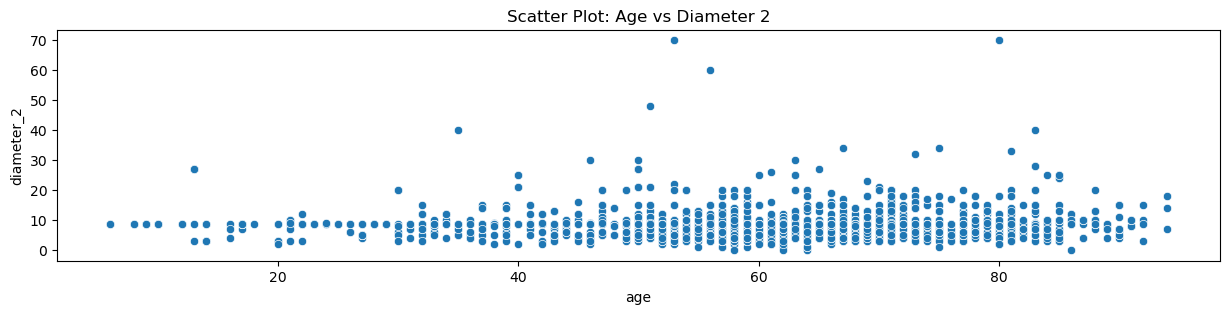

Gráfico guardado como: scatter_background_father_mother.png


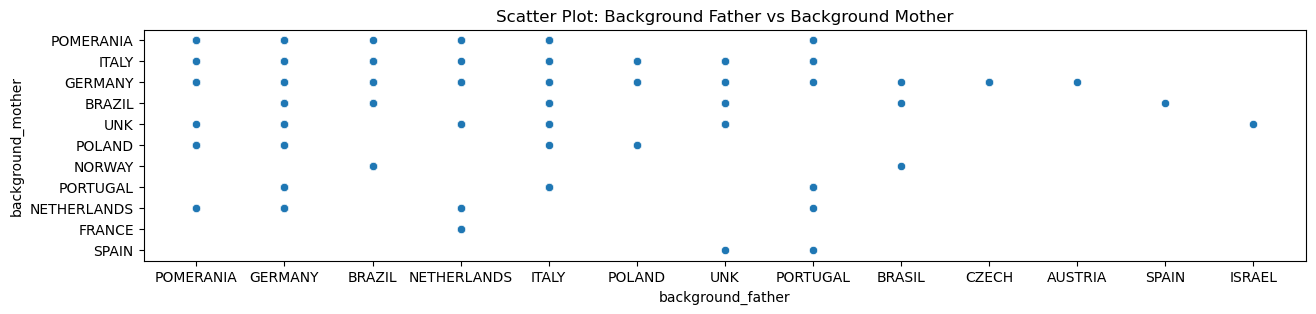

Gráfico guardado como: box_drink_age.png


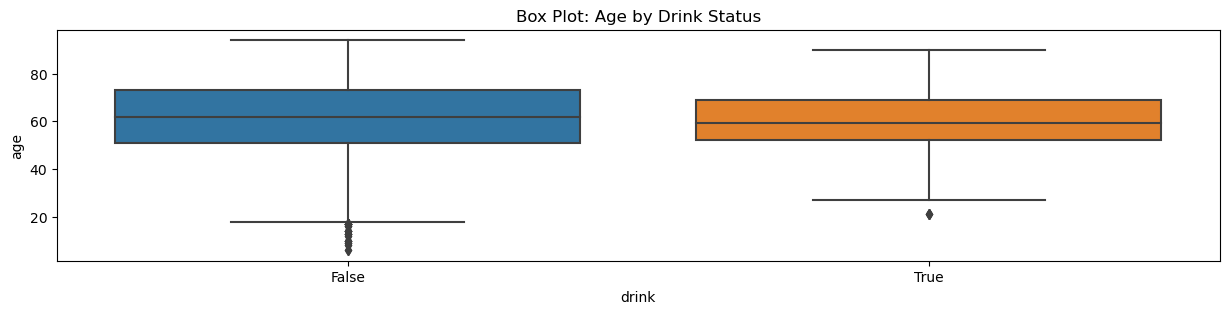

Gráfico guardado como: box_smoke_age.png


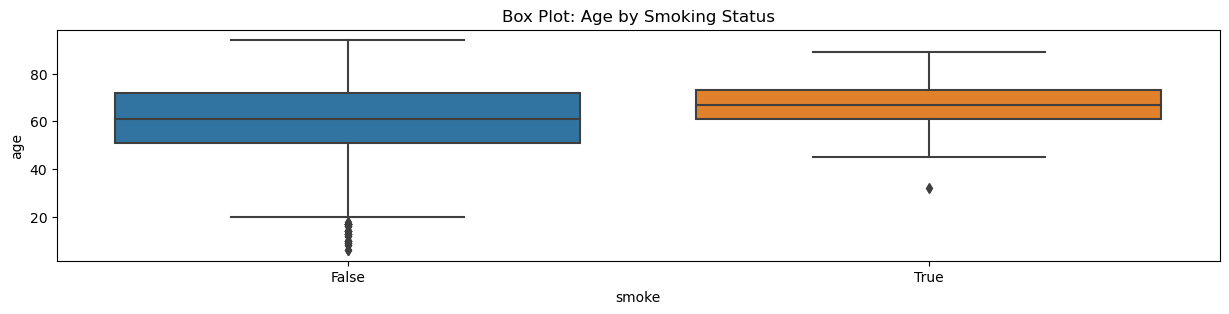

Gráfico guardado como: box_gender_diameter2.png


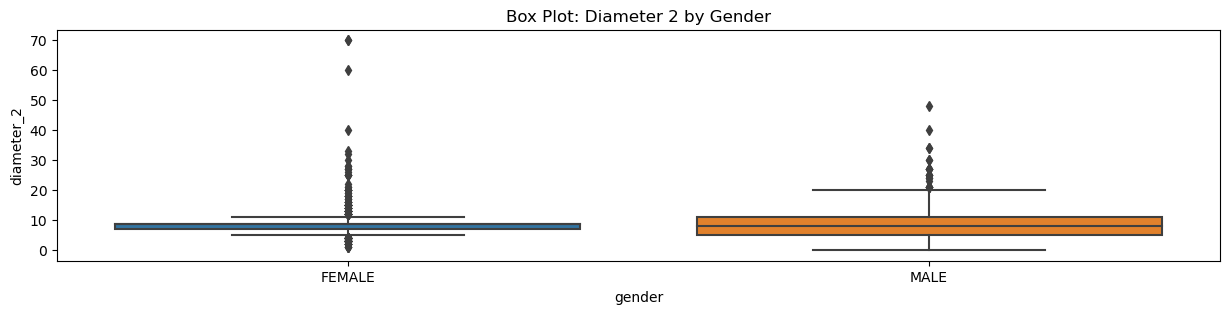

In [19]:
# Llamadas a la función para generar los 5 gráficos de los 5 descriptores

# 1. Scatter Plot: 'age' vs 'diameter_2'
generar_graficos(
    df=df_imputado, 
    var_x='age', 
    var_y='diameter_2', 
    tipo_grafico="scatter", 
    guardar=True, 
    nombre_archivo="scatter_age_diameter2.png", 
    titulo="Scatter Plot: Age vs Diameter 2"
)

# 2. Scatter Plot: 'background_father' vs 'background_mother'
generar_graficos(
    df=df_imputado, 
    var_x='background_father', 
    var_y='background_mother', 
    tipo_grafico="scatter", 
    guardar=True, 
    nombre_archivo="scatter_background_father_mother.png", 
    titulo="Scatter Plot: Background Father vs Background Mother"
)

# 3. Box Plot: 'drink' vs 'age'
generar_graficos(
    df=df_imputado, 
    var_x='drink', 
    var_y='age', 
    tipo_grafico="box", 
    guardar=True, 
    nombre_archivo="box_drink_age.png", 
    titulo="Box Plot: Age by Drink Status"
)

# 4. Box Plot: 'smoke' vs 'age'
generar_graficos(
    df=df_imputado, 
    var_x='smoke', 
    var_y='age', 
    tipo_grafico="box", 
    guardar=True, 
    nombre_archivo="box_smoke_age.png", 
    titulo="Box Plot: Age by Smoking Status"
)

# 5. Box Plot: 'gender' vs 'diameter_2'
generar_graficos(
    df=df_imputado, 
    var_x='gender', 
    var_y='diameter_2', 
    tipo_grafico="box", 
    guardar=True, 
    nombre_archivo="box_gender_diameter2.png", 
    titulo="Box Plot: Diameter 2 by Gender"
)


Las variables categóricas como gender, drink, y smoke tienen una relación limitada con variables numéricas como age y diameter_2.
Los antecedentes familiares (background_father, background_mother) muestran agrupamientos, lo que podría ser útil para identificar características regionales.
Utilidad para el modelado:

Los gráficos ayudan a confirmar qué variables podrían ser relevantes para un modelo predictivo y cuáles tienen poca relación aparente.

In [20]:
df_imputado.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2298 entries, 0 to 2297
Data columns (total 23 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   smoke                2298 non-null   bool   
 1   drink                2298 non-null   bool   
 2   background_father    2298 non-null   object 
 3   background_mother    2298 non-null   object 
 4   age                  2298 non-null   int64  
 5   pesticide            2298 non-null   bool   
 6   gender               2298 non-null   object 
 7   skin_cancer_history  2298 non-null   bool   
 8   cancer_history       2298 non-null   bool   
 9   has_piped_water      2298 non-null   bool   
 10  has_sewage_system    2298 non-null   bool   
 11  fitspatrick          2298 non-null   float64
 12  region               2298 non-null   object 
 13  diameter_1           2298 non-null   float64
 14  diameter_2           2298 non-null   float64
 15  diagnostic           2298 non-null   o

Antes de seguir con el escalamiento, voy a convertir a numero tanto las variables booleanas como object

In [21]:
# Función para transformar a número columnas object y bool, excluyendo la variable objetivo (esta funcion no se solcitaba pero se añadio)
# Se usará get_dummies ya que para categorías no ordinales es mejor

def convertir_a_numerico(df, target):
    """
    Convierte variables de tipo object y bool a variables dummy (one-hot encoding), 
    aplicando LabelEncoder a la variable objetivo.

    Args:
        df (pd.DataFrame): DataFrame original.
        target (str): Nombre de la variable objetivo.

    Returns:
        pd.DataFrame: DataFrame con las variables categóricas convertidas a dummies y la variable objetivo codificada.
        list: Lista de columnas que fueron codificadas (excluyendo la variable objetivo).
        LabelEncoder: Instancia del LabelEncoder utilizada para la variable objetivo.
    """
    df_numerico = df.copy()
    columnas_codificadas = []  # Lista para guardar las columnas transformadas

    # Codificar la variable objetivo con LabelEncoder
    label_encoder = LabelEncoder()
    if target in df_numerico.columns:
        df_numerico[target] = label_encoder.fit_transform(df_numerico[target])

    # Transformar las demás columnas categóricas con get_dummies
    for col in df_numerico.columns:
        if col != target and (df_numerico[col].dtype == 'object' or df_numerico[col].dtype == 'bool'):
            # Añadir la columna a la lista de codificadas
            columnas_codificadas.append(col)

    # Aplicar pd.get_dummies para las columnas categóricas excepto la variable objetivo
    df_numerico = pd.get_dummies(df_numerico, columns=columnas_codificadas, drop_first=True)

    return df_numerico, columnas_codificadas, label_encoder

In [22]:
# Aplicar la función al DataFrame imputado
df_numerico, columnas_codificadas,label_encoder = convertir_a_numerico(df_imputado,'diagnostic')

# Verificar los cambios
print(columnas_codificadas)
print(df_numerico.head())
print(df_numerico.dtypes)

['smoke', 'drink', 'background_father', 'background_mother', 'pesticide', 'gender', 'skin_cancer_history', 'cancer_history', 'has_piped_water', 'has_sewage_system', 'region', 'itch', 'grew', 'hurt', 'changed', 'bleed', 'elevation', 'biopsed']
   age  fitspatrick  diameter_1  diameter_2  diagnostic  smoke_True  \
0    8          2.0   11.897055    8.852209           3           0   
1   55          3.0    6.000000    5.000000           1           0   
2   77          2.0   11.897055    8.852209           0           0   
3   75          2.0   11.897055    8.852209           0           0   
4   79          1.0    5.000000    5.000000           1           0   

   drink_True  background_father_BRASIL  background_father_BRAZIL  \
0           0                         0                         0   
1           0                         0                         0   
2           0                         0                         0   
3           0                         0               

In [23]:
# Info del dataframe con transformacion a numericas
df_numerico.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2298 entries, 0 to 2297
Data columns (total 61 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   age                            2298 non-null   int64  
 1   fitspatrick                    2298 non-null   float64
 2   diameter_1                     2298 non-null   float64
 3   diameter_2                     2298 non-null   float64
 4   diagnostic                     2298 non-null   int32  
 5   smoke_True                     2298 non-null   uint8  
 6   drink_True                     2298 non-null   uint8  
 7   background_father_BRASIL       2298 non-null   uint8  
 8   background_father_BRAZIL       2298 non-null   uint8  
 9   background_father_CZECH        2298 non-null   uint8  
 10  background_father_GERMANY      2298 non-null   uint8  
 11  background_father_ISRAEL       2298 non-null   uint8  
 12  background_father_ITALY        2298 non-null   u

In [24]:
df_numerico.head(10)

,age,fitspatrick,diameter_1,diameter_2,diagnostic,smoke_True,drink_True,background_father_BRASIL,background_father_BRAZIL,background_father_CZECH,...,grew_UNK,hurt_True,hurt_UNK,changed_True,changed_UNK,bleed_True,bleed_UNK,elevation_True,elevation_UNK,biopsed_True
0,8,2.0,11.897055,8.852209,3,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,55,3.0,6.000000,5.000000,1,0,0,0,0,0,...,0,0,0,1,0,1,0,1,0,1
2,77,2.0,11.897055,8.852209,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,75,2.0,11.897055,8.852209,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,79,1.0,5.000000,5.000000,1,0,1,0,0,0,...,0,0,0,0,0,1,0,1,0,1
5,53,2.0,11.897055,8.852209,5,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
6,52,3.0,15.000000,10.000000,1,0,1,0,0,0,...,0,0,0,1,0,1,0,1,0,1
7,74,1.0,15.000000,10.000000,1,0,0,0,0,0,...,0,1,0,0,0,1,0,1,0,1
8,68,2.0,11.897055,8.852209,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
9,58,1.0,9.000000,7.000000,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Ahora todas las variables son numericas

In [25]:
def transformar_datos(df, columnas, estrategias, excluir=None):
    """
    Aplica normalización Z-score o escalamiento a los datos, excluyendo columnas específicas.

    Args:
        df (pd.DataFrame): DataFrame original.
        columnas (list): Lista de columnas a transformar.
        estrategias (list): Lista de estrategias para cada columna ('zscore', 'minmax').
        excluir (list): Lista de columnas a excluir de las transformaciones.

    Returns:
        pd.DataFrame: DataFrame modificado con las transformaciones aplicadas.
    """
    df_transformado = df.copy()
    scalers = {
        'zscore': StandardScaler(),
        'minmax': MinMaxScaler()
    }
    
    # Excluir columnas especificadas
    if excluir:
        columnas = [col for col in columnas if col not in excluir]
    
    for col, estrategia in zip(columnas, estrategias):
        if col not in df_transformado.columns:
            print(f"Advertencia: La columna '{col}' no existe en el DataFrame. Se omitirá.")
            continue
        
        if estrategia not in scalers:
            print(f"Estrategia '{estrategia}' no reconocida. Se omitirá la columna '{col}'.")
            continue
        
        # Aplicar la transformación
        scaler = scalers[estrategia]
        df_transformado[col] = scaler.fit_transform(df_transformado[[col]])
        
        # Convertir a enteros si se usa MinMaxScaler
        if estrategia == 'minmax':
            df_transformado[col] = df_transformado[col].round().astype(int)
    
    return df_transformado

Tipo de estrategia usada para cada descriptor (columna)


Para columnas categóricas representadas como números (binarias o con valores discretos): smoke, drink, pesticide, gender, skin_cancer_history, cancer_history, has_piped_water, has_sewage_system, itch, grew, hurt, changed, bleed, elevation, biopsed. a estas variables como se les aplico get dummies y no se escalaran (ya que no es necesario hacerlo tampoco)

Para la variable objetivo diagnostic se aplico label Encoder

Usar zscore (Estandarización):

Para columnas numéricas continuas o con un rango amplio: age, fitspatrick, diameter_1, diameter_2.
Se aplicara el zcore (estandarización) ya que es lo mejor para variables numerericas continuas.

In [26]:
# Definir las columnas numéricas continuas que necesitan z-score
columnas_a_transformar = ['age', 'fitspatrick', 'diameter_1', 'diameter_2']

# Filtrar automáticamente las estrategias para las columnas numéricas continuas
estrategias = ['zscore' for col in columnas_a_transformar]

# Aplicar la función de transformación únicamente a las columnas seleccionadas
df_transformado = transformar_datos(df_numerico, columnas=columnas_a_transformar, estrategias=estrategias)

# Mostrar las primeras filas del DataFrame transformado
print("DataFrame transformado (solo columnas numéricas continuas escaladas):")
print(df_transformado.head())

DataFrame transformado (solo columnas numéricas continuas escaladas):
        age  fitspatrick  diameter_1    diameter_2  diagnostic  smoke_True  \
0 -3.301454    -0.287388    0.000000  3.801625e-16           3           0   
1 -0.343881     1.376130   -0.847312 -8.244207e-01           1           0   
2  1.040515    -0.287388    0.000000  3.801625e-16           0           0   
3  0.914661    -0.287388    0.000000  3.801625e-16           0           0   
4  1.166369    -1.950906   -0.990996 -8.244207e-01           1           0   

   drink_True  background_father_BRASIL  background_father_BRAZIL  \
0           0                         0                         0   
1           0                         0                         0   
2           0                         0                         0   
3           0                         0                         0   
4           1                         0                         0   

   background_father_CZECH  ...  grew_UNK  hur

En resumen para las columnas continuas (zscore) se estandarizan para centrar y escalar.
Para las columnas categóricas discretas no se aplico escalamiento ya que a ellas se les aplico get_dummies y ademas no tiene sentido escalarlas (a la variable objetivo diagnostic se aplico label encoder)

In [27]:
# Asi quedaria el dataset transformado que se usara para lo que viene
df_transformado

,age,fitspatrick,diameter_1,diameter_2,diagnostic,smoke_True,drink_True,background_father_BRASIL,background_father_BRAZIL,background_father_CZECH,...,grew_UNK,hurt_True,hurt_UNK,changed_True,changed_UNK,bleed_True,bleed_UNK,elevation_True,elevation_UNK,biopsed_True
0,-3.301454,-0.287388,0.000000,3.801625e-16,3,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,-0.343881,1.376130,-0.847312,-8.244207e-01,1,0,0,0,0,0,...,0,0,0,1,0,1,0,1,0,1
2,1.040515,-0.287388,0.000000,3.801625e-16,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0.914661,-0.287388,0.000000,3.801625e-16,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1.166369,-1.950906,-0.990996,-8.244207e-01,1,0,1,0,0,0,...,0,0,0,0,0,1,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2293,0.788807,-0.287388,0.000000,3.801625e-16,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2294,-0.343881,1.376130,0.158476,6.736666e-01,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
2295,0.851734,-0.287388,0.000000,3.801625e-16,5,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2296,-0.155100,1.376130,-0.990996,-1.038433e+00,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1


In [28]:
# Tado quedo numerico y con escalamiento
df_transformado.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2298 entries, 0 to 2297
Data columns (total 61 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   age                            2298 non-null   float64
 1   fitspatrick                    2298 non-null   float64
 2   diameter_1                     2298 non-null   float64
 3   diameter_2                     2298 non-null   float64
 4   diagnostic                     2298 non-null   int32  
 5   smoke_True                     2298 non-null   uint8  
 6   drink_True                     2298 non-null   uint8  
 7   background_father_BRASIL       2298 non-null   uint8  
 8   background_father_BRAZIL       2298 non-null   uint8  
 9   background_father_CZECH        2298 non-null   uint8  
 10  background_father_GERMANY      2298 non-null   uint8  
 11  background_father_ISRAEL       2298 non-null   uint8  
 12  background_father_ITALY        2298 non-null   u

In [29]:
# Funcion para generar set de entrenamiento y testeo con separacion estratificada
def dividir_datos(df, target, test_size=0.3, random_state=50):
    """
    Divide un DataFrame en conjuntos de entrenamiento y prueba con separación estratificada.

    Args:
        df (pd.DataFrame): DataFrame completo.
        target (str): Nombre de la columna objetivo.
        test_size (float): Proporción del conjunto de prueba (por defecto 0.2).
        random_state (int): Semilla para reproducibilidad (por defecto 42).

    Returns:
        X_train, X_test, y_train, y_test: Conjuntos de datos divididos.
    """
    if target not in df.columns:
        raise ValueError(f"La columna objetivo '{target}' no existe en el DataFrame.")
    
    # Dividir datos y etiquetas
    X = df.drop(columns=[target])
    y = df[target]
    
    # División estratificada
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, stratify=y, random_state=random_state
    )
    
    return X_train, X_test, y_train, y_test

In [30]:
# Llamar a la función para dividir los datos
X_train, X_test, y_train, y_test = dividir_datos(df_transformado, target='diagnostic')

# Mostrar información de los conjuntos generados
print("Tamaño del conjunto de entrenamiento:", X_train.shape, y_train.shape)
print("Tamaño del conjunto de prueba:", X_test.shape, y_test.shape)

Tamaño del conjunto de entrenamiento: (1608, 60) (1608,)
Tamaño del conjunto de prueba: (690, 60) (690,)


In [31]:
# Se consolidan las funciones en una clase llamada Preprocesamiento, se excluiran las funciones para analisis descriptivo
# y graficos ya que no son parte del preprocesamiento sino del analisis exploratorio ya realizado

class Preprocesamiento:
    def __init__(self, test_size=0.2, random_state=42):
        """
        Inicialización de la clase Preprocesamiento.

        Args:
            test_size (float): Proporción del conjunto de prueba (por defecto 0.2).
            random_state (int): Semilla para reproducibilidad (por defecto 42).
        """
        self.test_size = test_size
        self.random_state = random_state
        self.label_encoders = {}
        self.scalers = {}
        self.target_encoder = None  # Para guardar el LabelEncoder de la variable objetivo

    def cargar_datos(self, filepath):
        """
        Cargar datos desde un archivo CSV.

        Args:
            filepath (str): Ruta del archivo CSV.

        Returns:
            pd.DataFrame: DataFrame cargado.
        """
        try:
            df = pd.read_csv(filepath)
            print("Datos cargados correctamente.")
            return df
        except Exception as e:
            print(f"Error al cargar los datos: {e}")
            return None

    def imputar_datos(self, df, columns, strategies):
        """
        Imputar datos faltantes según diferentes estrategias.

        Args:
            df (pd.DataFrame): DataFrame original.
            columns (list): Lista de columnas a imputar.
            strategies (list): Estrategias para cada columna ('mean', 'median', 'mode').

        Returns:
            pd.DataFrame: DataFrame imputado.
        """
        imputado = df.copy()
        for col, strategy in zip(columns, strategies):
            if col not in imputado.columns:
                print(f"Advertencia: La columna '{col}' no existe en el DataFrame.")
                continue
            if strategy == 'mean':
                imputado[col].fillna(imputado[col].mean(), inplace=True)
            elif strategy == 'median':
                imputado[col].fillna(imputado[col].median(), inplace=True)
            elif strategy == 'mode':
                imputado[col].fillna(imputado[col].mode()[0], inplace=True)
            else:
                print(f"Estrategia desconocida para '{col}': {strategy}")
        return imputado

    def convertir_a_numerico(self, df, target):
        """
        Convierte variables de tipo object y bool a variables dummy (one-hot encoding),
        aplicando LabelEncoder a la variable objetivo.

        Args:
            df (pd.DataFrame): DataFrame original.
            target (str): Nombre de la variable objetivo.

        Returns:
            pd.DataFrame: DataFrame con las variables categóricas convertidas a dummies y la variable objetivo codificada.
            list: Lista de columnas que fueron codificadas (excluyendo la variable objetivo).
            LabelEncoder: Instancia del LabelEncoder utilizada para la variable objetivo.
        """
        df_numerico = df.copy()
        columnas_codificadas = []  # Lista para guardar las columnas transformadas

        # Codificar la variable objetivo con LabelEncoder
        self.target_encoder = LabelEncoder()
        if target in df_numerico.columns:
            df_numerico[target] = self.target_encoder.fit_transform(df_numerico[target])

        # Transformar las demás columnas categóricas con get_dummies
        for col in df_numerico.columns:
            if col != target and (df_numerico[col].dtype == 'object' or df_numerico[col].dtype == 'bool'):
                # Añadir la columna a la lista de codificadas
                columnas_codificadas.append(col)

        # Aplicar pd.get_dummies para las columnas categóricas excepto la variable objetivo
        df_numerico = pd.get_dummies(df_numerico, columns=columnas_codificadas, drop_first=True)

        return df_numerico, columnas_codificadas

    def transformar_datos(self, df, columnas, estrategias, excluir=None):
        """
        Aplica normalización Z-score o escalamiento a los datos, excluyendo columnas específicas.

        Args:
            df (pd.DataFrame): DataFrame original.
            columnas (list): Lista de columnas a transformar.
            estrategias (list): Lista de estrategias para cada columna ('zscore', 'minmax').
            excluir (list): Lista de columnas a excluir de las transformaciones.

        Returns:
            pd.DataFrame: DataFrame modificado con las transformaciones aplicadas.
        """
        df_transformado = df.copy()
        scalers = {
            'zscore': StandardScaler(),
            'minmax': MinMaxScaler()
        }

        # Excluir columnas especificadas
        if excluir:
            columnas = [col for col in columnas if col not in excluir]

        for col, estrategia in zip(columnas, estrategias):
            if col not in df_transformado.columns:
                print(f"Advertencia: La columna '{col}' no existe en el DataFrame. Se omitirá.")
                continue

            if estrategia not in scalers:
                print(f"Estrategia '{estrategia}' no reconocida. Se omitirá la columna '{col}'.")
                continue

            # Aplicar la transformación
            scaler = scalers[estrategia]
            df_transformado[col] = scaler.fit_transform(df_transformado[[col]])
            self.scalers[col] = scaler

            # Convertir a enteros si la estrategia es MinMaxScaler
            if estrategia == 'minmax':
                df_transformado[col] = df_transformado[col].round().astype(int)

        return df_transformado

    def dividir_datos(self, df, target):
        """
        Dividir el DataFrame en conjuntos de entrenamiento y prueba.

        Args:
            df (pd.DataFrame): DataFrame original.
            target (str): Columna objetivo.

        Returns:
            X_train, X_test, y_train, y_test: Conjuntos divididos.
        """
        if target not in df.columns:
            raise ValueError(f"La columna objetivo '{target}' no existe.")
        X = df.drop(columns=[target])
        y = df[target]
        return train_test_split(X, y, test_size=self.test_size, stratify=y, random_state=self.random_state)

    def ejecutar_procesamiento(self, filepath, imputar_cols, imputar_strategies, transformar_cols, transformar_strategies, target):
        """
        Ejecutar el flujo completo de procesamiento.

        Args:
            filepath (str): Ruta del archivo CSV.
            imputar_cols (list): Columnas a imputar.
            imputar_strategies (list): Estrategias de imputación.
            transformar_cols (list): Columnas a transformar.
            transformar_strategies (list): Estrategias de transformación.
            target (str): Columna objetivo.

        Returns:
            X_train, X_test, y_train, y_test: Conjuntos procesados.
            list: Lista de columnas codificadas.
        """
        # Cargar datos
        df = self.cargar_datos(filepath)
        if df is None:
            return None, None, None, None

        # Imputar datos
        df = self.imputar_datos(df, imputar_cols, imputar_strategies)

        # Convertir a formato numérico
        df, columnas_codificadas = self.convertir_a_numerico(df, target)

        # Transformar datos
        df = self.transformar_datos(df, transformar_cols, transformar_strategies, excluir=columnas_codificadas)

        # Dividir datos
        X_train, X_test, y_train, y_test = self.dividir_datos(df, target)

        return X_train, X_test, y_train, y_test, columnas_codificadas

In [32]:
# Crear una instancia de la clase Preprocesamiento
preprocesador = Preprocesamiento(test_size=0.2, random_state=42)

# Ejecutar el procesamiento completo
try:
    X_train_pre, X_test_pre, y_train_pre, y_test_pre, columnas_codificadas = preprocesador.ejecutar_procesamiento(
        filepath="metadatos.csv",  # Ruta al archivo CSV
        imputar_cols=['smoke', 'drink'],  # Columnas a imputar
        imputar_strategies=['mode', 'mode'],  # Estrategias para imputar
        transformar_cols=['age', 'diameter_1', 'diameter_2'],  # Columnas a transformar
        transformar_strategies=['zscore', 'zscore', 'zscore'],  # Estrategias de transformación
        target='diagnostic'  # Columna objetivo
    )

    # Verificar los conjuntos generados
    print("Tamaño del conjunto de entrenamiento:", X_train_pre.shape)
    print("Tamaño del conjunto de prueba:", X_test_pre.shape)
    print("Columnas codificadas:", columnas_codificadas)
except Exception as e:
    print(f"Error durante el preprocesamiento: {e}")


Datos cargados correctamente.
Tamaño del conjunto de entrenamiento: (1838, 3730)
Tamaño del conjunto de prueba: (460, 3730)
Columnas codificadas: ['patient_id', 'smoke', 'drink', 'background_father', 'background_mother', 'pesticide', 'gender', 'skin_cancer_history', 'cancer_history', 'has_piped_water', 'has_sewage_system', 'region', 'itch', 'grew', 'hurt', 'changed', 'bleed', 'elevation', 'img_id', 'biopsed']


Como en el trabajo no se especifica y consulte al profesor ( no es estrictamente necesario usar la clase y los metodos ya que no se indica en el enunciado) por ende usaremos los conjuntos de entrenamiento y testeo generados a partir del dataframe (df_transformado), sin utilizar los metodos de esta clase

## 2.2 Entrenamiento de modelos

In [33]:
# Se define funcion clasificador
# **kwargs: Proporciona flexibilidad y permite personalizar los modelos con parámetros adicionales. asi que se añadio como parametro extra
# Se añadio como parametro extra el random_state (no lo pedia en el enunciado pero se añadio)

def clasificador(tipo_clasificador, path_guardado, X_train, y_train,random_state=None, **kwargs):
    """
    Ajustar y guardar un clasificador.

    Args:
        tipo_clasificador (str): Tipo de clasificador ('naive_bayes' o 'logistic_regression').
        path_guardado (str): Ruta donde se guardará el modelo.
        X_train (pd.DataFrame): Conjunto de características de entrenamiento.
        y_train (pd.Series): Etiquetas del conjunto de entrenamiento.
        random_state (int, optional): Semilla para reproducibilidad. Se aplica a modelos que lo soportan.
        **kwargs: Argumentos adicionales para los clasificadores.

    Returns:
        modelo: El modelo ajustado.
    """
    # Selección del modelo
    if tipo_clasificador == "naive_bayes":
        modelo = GaussianNB(**kwargs)
    elif tipo_clasificador == "logistic_regression":
        modelo = LogisticRegression(random_state=random_state, **kwargs)
    else:
        raise ValueError(f"Tipo de clasificador '{tipo_clasificador}' no soportado.")
    
    # Ajustar el modelo
    modelo.fit(X_train, y_train)
    
    # Guardar el modelo en el archivo especificado
    joblib.dump(modelo, path_guardado)
    print(f"Modelo guardado en: {path_guardado}")
    
    return modelo

In [34]:
# Ajustar y guardar un modelo Naive Bayes
modelo_nb = clasificador(
    tipo_clasificador="naive_bayes",
    path_guardado="modelo_naive_bayes.pkl",
    X_train=X_train,
    y_train=y_train
)

Modelo guardado en: modelo_naive_bayes.pkl


In [35]:
# Se añade max_iter=1000 para que converga

from sklearn.linear_model import LogisticRegression
import joblib

modelo_lr = clasificador(
    tipo_clasificador="logistic_regression",
    path_guardado="modelo_logistic_regression.pkl",
    X_train=X_train,
    y_train=y_train,
    random_state=42,  # Semilla para reproducibilidad
    max_iter=1000
)

Modelo guardado en: modelo_logistic_regression.pkl


In [36]:
def evaluar_rendimiento(modelo=None, path_modelo=None, X=None, y=None, tipo_analisis="metricas"):
    """
    Evaluar el rendimiento de un modelo entrenado.

    Args:
        modelo: Modelo entrenado directamente (opcional).
        path_modelo (str): Ruta del modelo guardado (opcional).
        X (pd.DataFrame): Conjunto de características para evaluar.
        y (pd.Series): Etiquetas verdaderas del conjunto de evaluación.
        tipo_analisis (str): Tipo de análisis ('matriz_confusion' o 'metricas').

    Returns:
        dict: Métricas calculadas si tipo_analisis es 'metricas', de lo contrario None.
    """
    # Cargar el modelo desde el archivo si se proporciona un path
    if path_modelo:
        try:
            modelo = joblib.load(path_modelo)
            print("Modelo cargado correctamente desde el archivo.")
        except Exception as e:
            print(f"Error al cargar el modelo: {e}")
            return None
    elif modelo is None:
        print("Error: Se debe proporcionar un modelo entrenado o una ruta al modelo guardado.")
        return None

    # Realizar predicciones
    try:
        y_pred = modelo.predict(X)
    except Exception as e:
        print(f"Error al predecir con el modelo: {e}")
        return None

    # Análisis de la matriz de confusión
    if tipo_analisis == 'matriz_confusion':
        matriz = confusion_matrix(y, y_pred)
        print("\nMatriz de Confusión:")
        print(matriz)
        return None

    # Cálculo de métricas de evaluación
    elif tipo_analisis == 'metricas':
        try:
            accuracy = accuracy_score(y, y_pred)
            recall = recall_score(y, y_pred, average='weighted', zero_division=1)
            precision = precision_score(y, y_pred, average='weighted', zero_division=1)
            f1 = f1_score(y, y_pred, average='weighted', zero_division=1)

            metricas = {
                'accuracy': accuracy,
                'recall': recall,
                'precision': precision,
                'f1_score': f1
            }

            print("\nMétricas de Evaluación:")
            for key, value in metricas.items():
                print(f"{key.capitalize()}: {value:.4f}")

            return metricas
        except Exception as e:
            print(f"Error al calcular métricas: {e}")
            return None

    # Tipo de análisis no reconocido
    else:
        print("Tipo de análisis no reconocido. Use 'matriz_confusion' o 'metricas'.")
        return None

La funcion solo ajusta y guarda los modelos

In [37]:
evaluar_rendimiento(
    path_modelo="modelo_logistic_regression.pkl",
    X=X_test,
    y=y_test,
    tipo_analisis="matriz_confusion"
)

Modelo cargado correctamente desde el archivo.

Matriz de Confusión:
[[181  28   0   3   3   4]
 [ 11 234   1   0   8   0]
 [  2   6   6   2   0   0]
 [  6   3   2  56   0   6]
 [  3  40   1   1  13   0]
 [ 18   3   0   6   0  43]]


In [38]:
evaluar_rendimiento(
    path_modelo="modelo_naive_bayes.pkl",
    X=X_test,
    y=y_test,
    tipo_analisis="metricas"
)

Modelo cargado correctamente desde el archivo.

Métricas de Evaluación:
Accuracy: 0.1812
Recall: 0.1812
Precision: 0.4862
F1_score: 0.1079


{'accuracy': 0.18115942028985507,
 'recall': 0.18115942028985507,
 'precision': 0.48617081446418614,
 'f1_score': 0.10788880901888108}

Se llama a la funcion con ambos modelos ya guardados, y se sus metricas, recordar que aca son modelos vainilla sin hyperparametros, eso se hara en la siguiente función que mezclara tanto la funcion que define el clasificador como la que evalua el rendimiento

In [39]:
# Funcion para buscar el mejor modelo, usa las 2 funciones anteriores para probar distintos modelos
# Se prueba con varios hyperparametros distintos y selecciona el mejor modelo
# Ademas tiene como parametro la opcion de que seleccione los mejores X descriptores 
# es decir, si coloco 10 , entran todos los descriptores, pero solo los 10 mejores descriptores (según f_classif) se incluirán en el proceso de optimización de los modelos.
# Tambien elimina columnas con baja varianza

def optimizar_modelos_con_seleccion(X_train, y_train, X_test, y_test, num_features=None, random_state=42):
    """
    Optimizar hiperparámetros de modelos, seleccionar los mejores descriptores y elegir el mejor modelo.

    Args:
        X_train, y_train: Datos de entrenamiento.
        X_test, y_test: Datos de prueba.
        num_features (int): Número de descriptores a seleccionar. Si es None, usa todos.
        random_state (int): Semilla para reproducibilidad.

    Returns:
        dict: Información del mejor modelo.
    """
    resultados = []

    # Filtrar columnas con baja varianza
    var_threshold = 1e-6
    low_variance_cols = X_train.var()[X_train.var() <= var_threshold].index
    if low_variance_cols.any():
        print(f"Columnas eliminadas por baja varianza: {list(low_variance_cols)}")
        X_train = X_train.drop(columns=low_variance_cols)
        X_test = X_test.drop(columns=low_variance_cols)

    # Selección de descriptores
    if num_features:
        print(f"\nSeleccionando los mejores {num_features} descriptores con SelectKBest...")
        selector = SelectKBest(score_func=f_classif, k=num_features)
        X_train = selector.fit_transform(X_train, y_train)
        X_test = selector.transform(X_test)
        print(f"Descriptores seleccionados: {X_train.shape[1]}")
    else:
        print(f"Usando todos los descriptores: {X_train.shape[1]}")

    # Optimización de Logistic Regression
    print("\nOptimizando Logistic Regression...")
    param_grid_lr = [
        {'penalty': ['l1', 'l2'], 'C': [0.1, 1, 10], 'class_weight': [None, 'balanced'], 'solver': ['saga'], 'max_iter': [2000]},
        {'penalty': ['elasticnet'], 'C': [0.1, 1, 10], 'class_weight': [None, 'balanced'], 'solver': ['saga'], 'max_iter': [2000], 'l1_ratio': [0.5]},
    ]
    grid_lr = GridSearchCV(
        estimator=LogisticRegression(random_state=random_state),
        param_grid=param_grid_lr,
        scoring='f1_weighted',
        cv=3,
        verbose=1,
        n_jobs=-1
    )
    grid_lr.fit(X_train, y_train)

    mejor_lr = grid_lr.best_estimator_
    # Guardar y evaluar el mejor modelo
    path_lr = "mejor_logistic_regression.pkl"
    clasificador(
        tipo_clasificador="logistic_regression",
        path_guardado=path_lr,
        X_train=X_train,
        y_train=y_train,
        random_state=random_state,
        **grid_lr.best_params_
    )
    metricas_lr = evaluar_rendimiento(
        path_modelo=path_lr,
        X=X_test,
        y=y_test,
        tipo_analisis="metricas"
    )
    if metricas_lr:
        resultados.append({
            "modelo": "logistic_regression",
            "mejor_hiperparametros": grid_lr.best_params_,
            "metricas": metricas_lr
        })

    # Optimización de Naive Bayes
    print("\nOptimizando Naive Bayes...")
    prior_options = [None, [0.2, 0.2, 0.2, 0.2, 0.1, 0.1], [0.1, 0.1, 0.2, 0.2, 0.2, 0.2]]
    for priors in prior_options:
        try:
            path_nb = f"naive_bayes_priors_{str(priors)}.pkl"
            modelo_nb = clasificador(
                tipo_clasificador="naive_bayes",
                path_guardado=path_nb,
                X_train=X_train,
                y_train=y_train,
                priors=priors
            )
            metricas_nb = evaluar_rendimiento(
                path_modelo=path_nb,
                X=X_test,
                y=y_test,
                tipo_analisis="metricas"
            )
            if metricas_nb:
                resultados.append({
                    "modelo": "naive_bayes",
                    "priors": priors,
                    "metricas": metricas_nb
                })
        except Exception as e:
            print(f"Error al entrenar Naive Bayes con priors={priors}: {e}")

    # Seleccionar el mejor modelo basado en F1-score
    if resultados:
        mejor_modelo = max(resultados, key=lambda x: x['metricas']['f1_score'])
        print("\nMejor modelo seleccionado:")
        print(mejor_modelo)
    else:
        print("No se encontraron modelos válidos.")
        mejor_modelo = None

    return mejor_modelo


In [40]:
# Se llama a la función, buscando los 10 mejores descriptores
mejor_modelo = optimizar_modelos_con_seleccion(
    X_train, 
    y_train, 
    X_test, 
    y_test, 
    num_features=10  # Seleccionar los 10 mejores descriptores
)

Columnas eliminadas por baja varianza: ['background_father_SPAIN']

Seleccionando los mejores 10 descriptores con SelectKBest...
Descriptores seleccionados: 10

Optimizando Logistic Regression...
Fitting 3 folds for each of 18 candidates, totalling 54 fits
Modelo guardado en: mejor_logistic_regression.pkl
Modelo cargado correctamente desde el archivo.

Métricas de Evaluación:
Accuracy: 0.7188
Recall: 0.7188
Precision: 0.6634
F1_score: 0.6796

Optimizando Naive Bayes...
Modelo guardado en: naive_bayes_priors_None.pkl
Modelo cargado correctamente desde el archivo.

Métricas de Evaluación:
Accuracy: 0.3623
Recall: 0.3623
Precision: 0.7585
F1_score: 0.3501
Modelo guardado en: naive_bayes_priors_[0.2, 0.2, 0.2, 0.2, 0.1, 0.1].pkl
Modelo cargado correctamente desde el archivo.

Métricas de Evaluación:
Accuracy: 0.3623
Recall: 0.3623
Precision: 0.7031
F1_score: 0.3556
Modelo guardado en: naive_bayes_priors_[0.1, 0.1, 0.2, 0.2, 0.2, 0.2].pkl
Modelo cargado correctamente desde el archivo.

Métr

El modelo seleccionado es la regresión logistica.

**Los mejores hyperparametros seleccionados son:**

C: 10 Representa una regularización baja, permitiendo que el modelo ajuste mejor los datos. Esto puede ayudar a capturar patrones más complejos.

class_weight: None Indica que no se aplicó balance automático entre clases, por lo que el modelo considera que todas las clases tienen la misma importancia durante el entrenamiento.

max_iter: 2000 Aumenta el número máximo de iteraciones, asegurando la convergencia del modelo, especialmente en problemas complejos.

penalty: l1 Utiliza regularización Lasso, que favorece modelos más simples eliminando características irrelevantes.
solver: saga Es un algoritmo robusto y eficiente para manejar conjuntos de datos grandes y dispersos.

En cuanto a las metricas de evaluación:

**Accuracy: 0.7188**
Indica que el modelo clasificó correctamente el 71.88% de los ejemplos en el conjunto de prueba, lo cual es un indicador global aceptable.

**Recall: 0.7188**
Señala que el modelo recuperó el 71.88% de los ejemplos positivos. Esto sugiere que el modelo tiene un buen desempeño en la identificación de ejemplos relevantes.

**Precision: 0.6634**
El modelo es preciso en el 66.34% de sus predicciones positivas, lo que significa que una proporción de las predicciones positivas puede ser incorrecta. Esto deja margen para mejorar la precisión.

**F1-Score: 0.6796**
Combina precisión y recall en una métrica equilibrada, indicando que el modelo tiene un rendimiento general del 67.96%. Este puntaje sugiere un equilibrio razonable entre identificar ejemplos positivos y minimizar errores.



**En comparación con Naive Bayes:**

La regresion logistica obtuvo un accuracy significativamente mayor (71.88%) en comparación con Naive Bayes (36.23% en el mejor caso).
La regresion logistica tiene un recall considerablemente más alto (71.88%) frente al mejor recall de Naive Bayes (36.23%).
Precision
La regresion logistica supera a Naive Bayes en precisión general (66.34% frente a 75.85% en un caso específico de Naive Bayes con baja recall).
F1-Score
La regresion logistica logró un F1-Score mucho más alto (67.96%) que Naive Bayes (entre 35.01% y 29.07%). Esto indica que Logistic Regression tiene un mejor equilibrio entre precisión y recall.

El modelo de Regresión Logística es el mejor modelo para este conjunto de datos, basado en su desempeño superior en todas las métricas clave. Este resultado refleja que ademas tiene una mejor capacidad para capturar relaciones entre los descriptores y las clases objetivo. Es menos susceptible a las limitaciones de independencia de características que afectan el rendimiento de Naive Bayes.

Por esto la función selecciono a la regresión logistica como mejor función

## 2.3 Modelos basados en arboles

**Descripción aprendizaje modelo arbol clasificador**









**Descripción aprendizaje modelo random forest**






In [41]:
# Se mejora la función anterior para que incluya modelos decision_tree y random_forest

def clasificador(tipo_clasificador, path_guardado, X_train, y_train,random_state=None, **kwargs):
    """
    Ajustar y guardar un clasificador.

    Args:
        tipo_clasificador (str): Tipo de clasificador ('naive_bayes', 'logistic_regression', 'decision_tree', 'random_forest').
        path_guardado (str): Ruta donde se guardará el modelo.
        X_train (pd.DataFrame): Conjunto de características de entrenamiento.
        y_train (pd.Series): Etiquetas del conjunto de entrenamiento.
        random_state (int, optional): Semilla para reproducibilidad. Se aplica a modelos que lo soportan.
        **kwargs: Argumentos adicionales para los clasificadores.

    Returns:
        modelo: El modelo ajustado.
    """
    # Selección del modelo
    if tipo_clasificador == "naive_bayes":
        modelo = GaussianNB(**kwargs)
    elif tipo_clasificador == "logistic_regression":
        modelo = LogisticRegression(random_state=random_state, **kwargs)
    elif tipo_clasificador == "decision_tree":
        modelo = DecisionTreeClassifier(random_state=random_state, **kwargs)
    elif tipo_clasificador == "random_forest":
        modelo = RandomForestClassifier(random_state=random_state, **kwargs)
    else:
        raise ValueError(f"Tipo de clasificador '{tipo_clasificador}' no soportado.")
    
    # Ajustar el modelo
    modelo.fit(X_train, y_train)
    
    # Guardar el modelo en el archivo especificado
    joblib.dump(modelo, path_guardado)
    print(f"Modelo guardado en: {path_guardado}")
    
    return modelo

In [42]:
modelo_rf = clasificador(
    tipo_clasificador="random_forest",
    path_guardado="modelo_random_forest.pkl",
    X_train=X_train,
    y_train=y_train,
    #n_estimators=100,
    #$max_depth=10,
    #random_state=42
)

Modelo guardado en: modelo_random_forest.pkl


In [43]:
modelo_dt = clasificador(
    tipo_clasificador="decision_tree",
    path_guardado="modelo_decision_tree.pkl",
    X_train=X_train,
    y_train=y_train,
    #$criterion="gini",
    #$max_depth=5,
    #random_state=42
)


Modelo guardado en: modelo_decision_tree.pkl


In [44]:
# Se mejora la función para que tambien incluya random forest y decision tree
# Tambien se añadio que compare random forest y decision tree con naive bayes y regresion logistica
def optimizar_modelos_con_seleccion(X_train, y_train, X_test, y_test, num_features=None, random_state=42):
    """
    Optimizar hiperparámetros de modelos, seleccionar los mejores descriptores y comparar modelos.

    Args:
        X_train, y_train: Datos de entrenamiento.
        X_test, y_test: Datos de prueba.
        num_features (int): Número de descriptores a seleccionar. Si es None, usa todos.
        random_state (int): Semilla para reproducibilidad.

    Returns:
        dict: Comparación de resultados entre los modelos.
    """
    resultados = []

    # Filtrar columnas con baja varianza
    var_threshold = 1e-6  # Umbral mínimo de varianza
    low_variance_cols = X_train.var()[X_train.var() <= var_threshold].index
    if low_variance_cols.any():
        print(f"Columnas eliminadas por baja varianza: {list(low_variance_cols)}")
        X_train = X_train.drop(columns=low_variance_cols)
        X_test = X_test.drop(columns=low_variance_cols)

    # Selección de descriptores
    if num_features:
        print(f"\nSeleccionando los mejores {num_features} descriptores con SelectKBest...")
        selector = SelectKBest(score_func=f_classif, k=num_features)
        X_train = selector.fit_transform(X_train, y_train)
        X_test = selector.transform(X_test)
        print(f"Descriptores seleccionados: {X_train.shape[1]}")
    else:
        print(f"Usando todos los descriptores: {X_train.shape[1]}")

    # Lista de configuraciones para los modelos
    modelos = [
        {
            "tipo": "logistic_regression",
            "param_grid": [
                {'penalty': ['l1', 'l2'], 'C': [0.1, 1, 10], 'class_weight': [None, 'balanced'], 'solver': ['saga'], 'max_iter': [2000]},
                {'penalty': ['elasticnet'], 'C': [0.1, 1, 10], 'class_weight': [None, 'balanced'], 'solver': ['saga'], 'max_iter': [2000], 'l1_ratio': [0.5]}
            ],
            "estimator": LogisticRegression(random_state=random_state),
            "path": "mejor_logistic_regression.pkl"
        },
        {
            "tipo": "decision_tree",
            "param_grid": {
                'criterion': ['gini', 'entropy'],
                'max_depth': [5, 10, None],
                'min_samples_split': [2, 5, 10],
                'class_weight': [None, 'balanced']
            },
            "estimator": DecisionTreeClassifier(random_state=random_state),
            "path": "mejor_decision_tree.pkl"
        },
        {
            "tipo": "random_forest",
            "param_grid": {
                'n_estimators': [50, 100, 200],
                'max_depth': [5, 10, None],
                'min_samples_split': [2, 5, 10],
                'class_weight': [None, 'balanced']
            },
            "estimator": RandomForestClassifier(random_state=random_state),
            "path": "mejor_random_forest.pkl"
        }
    ]

    # Entrenar y evaluar modelos de tipo GridSearchCV
    for modelo_info in modelos:
        print(f"\nOptimizando {modelo_info['tipo']}...")
        grid_search = GridSearchCV(
            estimator=modelo_info['estimator'],
            param_grid=modelo_info['param_grid'],
            scoring='f1_weighted',
            cv=3,
            verbose=1,
            n_jobs=-1
        )
        grid_search.fit(X_train, y_train)

        mejor_modelo = grid_search.best_estimator_
        clasificador(
            tipo_clasificador=modelo_info['tipo'],
            path_guardado=modelo_info['path'],
            X_train=X_train,
            y_train=y_train,
            random_state=random_state,
            **grid_search.best_params_
        )
        metricas = evaluar_rendimiento(
            path_modelo=modelo_info['path'],
            X=X_test,
            y=y_test,
            tipo_analisis="metricas"
        )
        if metricas:
            resultados.append({
                "modelo": modelo_info['tipo'],
                "mejor_hiperparametros": grid_search.best_params_,
                "metricas": metricas
            })

    # Optimización de Naive Bayes
    print("\nOptimizando Naive Bayes...")
    prior_options = [None, [0.2, 0.2, 0.2, 0.2, 0.1, 0.1], [0.1, 0.1, 0.2, 0.2, 0.2, 0.2]]
    for priors in prior_options:
        try:
            path_nb = f"naive_bayes_priors_{str(priors)}.pkl"
            modelo_nb = clasificador(
                tipo_clasificador="naive_bayes",
                path_guardado=path_nb,
                X_train=X_train,
                y_train=y_train,
                priors=priors
            )
            metricas_nb = evaluar_rendimiento(
                path_modelo=path_nb,
                X=X_test,
                y=y_test,
                tipo_analisis="metricas"
            )
            if metricas_nb:
                resultados.append({
                    "modelo": "naive_bayes",
                    "priors": priors,
                    "metricas": metricas_nb
                })
        except Exception as e:
            print(f"Error al entrenar Naive Bayes con priors={priors}: {e}")

    # Comparar resultados
    print("\nComparación de resultados entre modelos:")
    for resultado in resultados:
        print(f"\nModelo: {resultado['modelo']}")
        print(f"Hiperparámetros: {resultado.get('mejor_hiperparametros', resultado.get('priors'))}")
        print(f"Métricas: {resultado['metricas']}")

    # Seleccionar el mejor modelo basado en F1-score
    mejor_modelo = max(resultados, key=lambda x: x['metricas']['f1_score'])
    print("\nMejor modelo seleccionado:")
    print(mejor_modelo)

    return mejor_modelo


In [45]:
# Se llama a la función, buscando los 15 mejores descriptores
mejor_modelo = optimizar_modelos_con_seleccion(
    X_train, 
    y_train, 
    X_test, 
    y_test, 
    num_features=15  # Seleccionar los 15 mejores descriptores
)

Columnas eliminadas por baja varianza: ['background_father_SPAIN']

Seleccionando los mejores 15 descriptores con SelectKBest...
Descriptores seleccionados: 15

Optimizando logistic_regression...
Fitting 3 folds for each of 18 candidates, totalling 54 fits
Modelo guardado en: mejor_logistic_regression.pkl
Modelo cargado correctamente desde el archivo.

Métricas de Evaluación:
Accuracy: 0.7232
Recall: 0.7232
Precision: 0.7170
F1_score: 0.6903

Optimizando decision_tree...
Fitting 3 folds for each of 36 candidates, totalling 108 fits
Modelo guardado en: mejor_decision_tree.pkl
Modelo cargado correctamente desde el archivo.

Métricas de Evaluación:
Accuracy: 0.7130
Recall: 0.7130
Precision: 0.6951
F1_score: 0.6994

Optimizando random_forest...
Fitting 3 folds for each of 54 candidates, totalling 162 fits
Modelo guardado en: mejor_random_forest.pkl
Modelo cargado correctamente desde el archivo.

Métricas de Evaluación:
Accuracy: 0.7203
Recall: 0.7203
Precision: 0.7336
F1_score: 0.7255

Opt

**Comparación Decision Tree con Naive Bayes:**

Accuracy:
Decision Tree: 71.30% frente a Naive Bayes: 37.68% (mejor caso).
Decision Tree demuestra una mejora significativa en la tasa de clasificación correcta.
F1-Score:
Decision Tree: 0.6994 frente a Naive Bayes: 0.3802 (mejor caso).
El F1-Score de Decision Tree es ampliamente superior, mostrando un equilibrio mejor entre precisión y recall.

**Comparación Decision Tree con Regresión Logística:**
Accuracy:
Decision Tree: 71.30% frente a Logistic Regression: 72.32%.
La Regresión Logística tiene una ligera ventaja en la tasa de clasificación correcta.

F1-Score:
Decision Tree: 0.6994 frente a Logistic Regression: 0.6903.
Aunque Decision Tree logra un F1-Score marginalmente mejor, ambos modelos tienen un rendimiento comparable.

Ambos modelos son competitivos, pero Logistic Regression tiene una ligera ventaja en términos globales de clasificación correcta, mientras que Decision Tree es una alternativa sólida con un desempeño equilibrado.

**Comparación Random forest con Naive Bayes:**

Accuracy:
Random Forest: 72.03% frente a Naive Bayes: 37.68% (mejor caso).
Random Forest supera ampliamente a Naive Bayes en la tasa de clasificación correcta.

F1-Score:
Random Forest: 0.7255 frente a Naive Bayes: 0.3802 (mejor caso).
Random Forest demuestra un mejor equilibrio entre precisión y recall, lo que lo posiciona como una opción mucho más efectiva.

Random Forest es significativamente mejor que Naive Bayes en todos los aspectos, resaltando su capacidad para manejar patrones complejos y relaciones no lineales.


**Comparación Random forest con Regresión Logística:**

Accuracy:
Random Forest: 72.03% frente a Logistic Regression: 72.32%.
Ambos modelos son comparables, con Logistic Regression mostrando una ventaja marginal.

F1-Score:
Random Forest: 0.7255 frente a Logistic Regression: 0.6903.
Random Forest muestra un mejor balance entre precisión y recall, superando claramente a Logistic Regression en esta métrica.

Aunque Logistic Regression tiene una ligera ventaja en accuracy, Random Forest ofrece un mejor equilibrio global de métricas y un desempeño destacado en precisión y F1-Score.

**Modelo final recomendado:**

El modelo seleccionado como mejor opción es Random Forest, que presenta los siguientes hiperparámetros óptimos:

class_weight: 'balanced' (asegura un balance adecuado entre las clases).
max_depth: 10 (controla la profundidad del árbol, evitando sobreajuste).
min_samples_split: 2 (mínima cantidad de muestras para dividir un nodo).
n_estimators: 200 (número de árboles en el bosque).
Resumen del Desempeño del Mejor Modelo:

Accuracy: 72.03%.
F1-Score: 0.7255.
Precision: 73.36%.
Recall: 72.03%.

Po ende este modelo logra el mejor equilibrio entre precisión, recall y exactitud, siendo ideal para predecir las clases de la variable objetivo diagnostic.